In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import glob

## 绘制基站分布图
基站信息文件base.csv，注意文件的编码格式cp936。

In [4]:
base=pd.read_csv('base.csv', encoding='CP936')
base.head()

,序号,MAC地址,X坐标,Y坐标,Z坐标
0,B1,A0:E6:F8:2D:19:BB,-1.1397,4.7248,2.0
1,B2,A0:E6:F8:25:D5:FB,1.7725,4.2468,2.0
2,B3,C4:BE:84:D5:3E:07,-1.1358,9.6442,2.0
3,B4,A0:E6:F8:25:BA:C9,1.7896,7.2496,2.0
4,B5,B0:B4:48:DE:19:B1,-1.1225,14.4456,2.0


In [5]:
print base.dtypes
# 考虑到定位不需要三维定位，Z坐标直接舍弃。
#TODO 从模型改进的角度，有没有可能借助Z坐标，进一步提升模型
data=base.loc[:, [u'序号', u'MAC地址', u'X坐标', u'Y坐标']]

序号        object
MAC地址     object
X坐标      float64
Y坐标      float64
Z坐标      float64
dtype: object


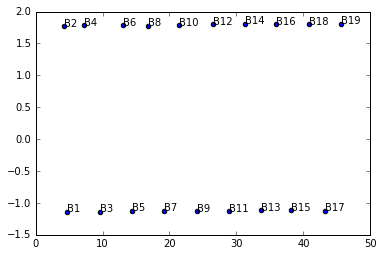

In [6]:
import matplotlib.pyplot as plt

x = base[u'X坐标'].tolist()
y = base[u'Y坐标'].tolist()
labels = base[u'序号'].tolist()
macs = base[u'MAC地址'].tolist()

fig, ax = plt.subplots()
ax.scatter(y, x)

for i, txt in enumerate(labels):
    ax.annotate(txt, (y[i], x[i]))

## 建立测距模型

### 1、根据MAC地址查找基站信息

In [7]:
b0mac = 'C4:BE:84:D5:3E:07'
b0idx = base.index[base[u'MAC地址'] == b0mac].tolist()
b0 = base.iloc[b0idx]
b0

,序号,MAC地址,X坐标,Y坐标,Z坐标
2,B3,C4:BE:84:D5:3E:07,-1.1358,9.6442,2.0


### 2、测距模型单站观测序列分析
首先，将Unix时间戳转换为标准时间。

In [8]:
import datetime
unix_ts = 1439111214.0
time = datetime.datetime.fromtimestamp(unix_ts) # 毫秒的情况下，需要除以1000
print time

2015-08-09 17:06:54


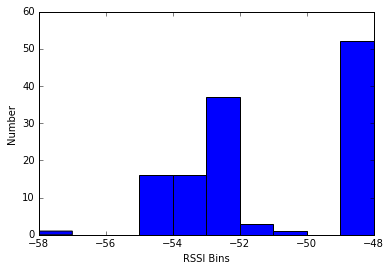

In [9]:
# 时间序列的影响大不大？？？
f = open(u'建立测距模型所需数据/0.6.txt', 'r')
rssi_all = [] # 存储蓝牙信号强度
t_all = [] # 存储观测的时间序列，从0开始，单位为s
t_min = 0
for line in f.readlines():
    t, _, mac, rssi = line.split()
    t =  datetime.datetime.fromtimestamp(long(t)/1000.0)
    if len(t_all)==0:
        t_min = t
        tmp = t-t_min
        t_all.append(tmp.total_seconds())
    else:
        tmp = t-t_min
        t_all.append(tmp.total_seconds())

    rssi_all.append(int(rssi))
    
f.close()

rssi_all = np.array(rssi_all)
plt.hist(rssi_all, bins=10)
plt.xlabel('RSSI Bins')
plt.ylabel('Number')

In [10]:
print('RSSI Mean: ', rssi_all.mean(), 'RSSI STD: ', rssi_all.std())

('RSSI Mean: ', -51.611111111111114, 'RSSI STD: ', 2.57574838014373)


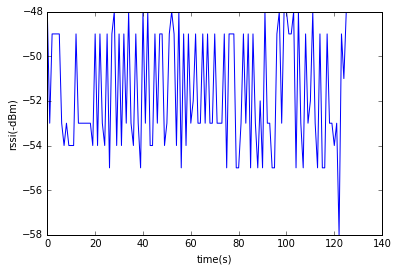

In [11]:
plt.plot(range(len(rssi_all)), rssi_all)
plt.xlabel('time(s)')
plt.ylabel('rssi(-dBm)')

### 2.1 单站观测数据滤波
提高数据观测质量，改进模型
https://www.kalmanfilter.net/default.aspx

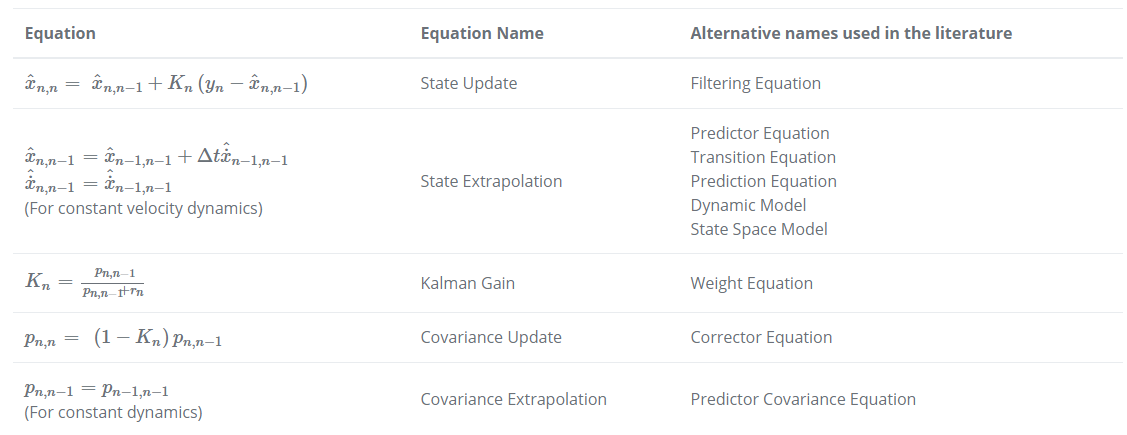

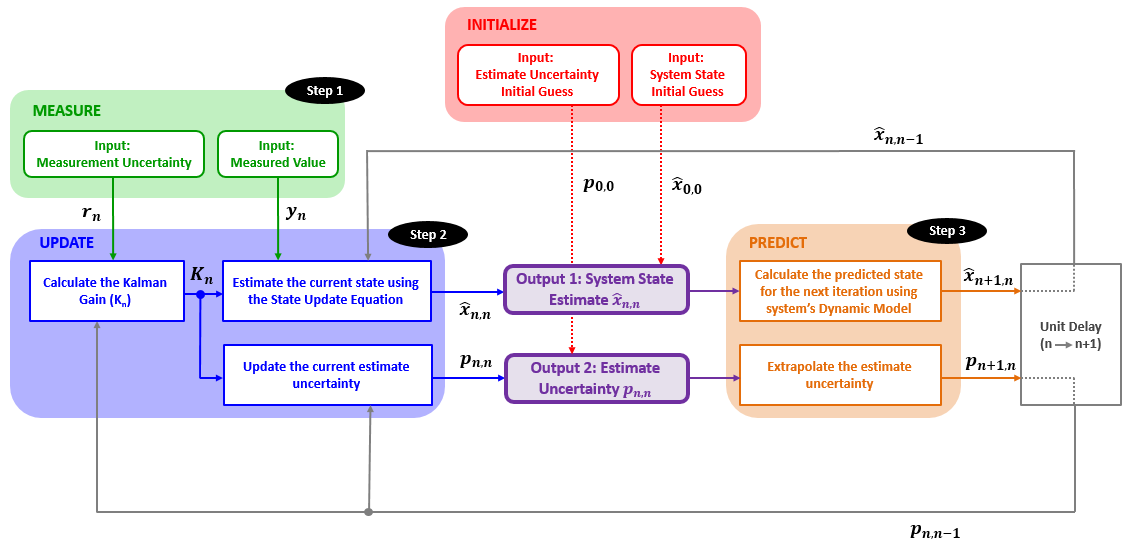

In [12]:
T = np.array(0.5)
print T.transpose()

0.5


In [13]:
class Kalman:
    def __init__(self, Q, R, start):
        self.A = 1 # transition matrix 转移矩阵？
        self.H = 1 # 从预测值到测量值的转换矩阵？
        self.P = 10 # 预测的不确定性，协方差矩阵
        self.Q = Q # 预测的外部无法估计的噪声协方差矩阵，将被叠加到P上
        self.R = R # 测量or传感器不确定性，(系统搭建好以后，通过测量统计实验获得)
        self.startValue = start
    
    def KalmanFilter(self, value):
        # 预测下一时刻的值
        predictValue = self.A*self.startValue # state extrapolation eq
        # 求预测下一时刻的协方差
        self.P = self.A*self.P*self.A+self.Q # covariance extrapolation eq
        # 计算Kalman增益
        kalmanGain = self.P*self.H/(self.H*self.P*self.H+self.R) # kalman gain eq
        # 修正结果，计算滤波值
        self.startValue = predictValue+kalmanGain*(value-predictValue) # state update eq
        # 更正后验估计
        self.P = (1-kalmanGain*self.H)*self.P # covariance update eq
        return self.startValue

# Q = 1 # 通过测距模型观测数据，进行估计
# R = 300 # 观测噪声协方差    
def kf(inputs, Q=0.1, R=9):
    outputs = []
    start = inputs[0]
    outputs.append(start)

    kalman1 = Kalman(Q, R, start)
    for value in inputs[1:]:
        outputs.append(kalman1.KalmanFilter(value))
    return np.array(outputs)

Input: RSSI Mean: -51.6111111111. RSSI STD: 2.57574838014
Output: RSSI Mean: -51.502387175. RSSI STD: 0.65023290699


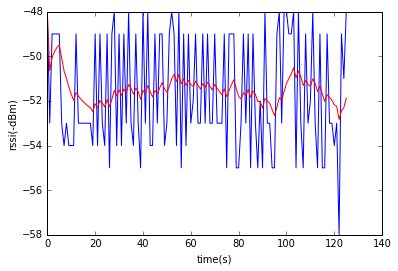

In [14]:
inputs = rssi_all
outputs = []

start = inputs[0]
outputs.append(start)
Q = 0.1 # 预测过程中外部噪声的方差
R = 9 # 测量的方差
kalman1 = Kalman(Q, R, start)
for value in inputs[1:]:
    outputs.append(kalman1.KalmanFilter(value))
    
plt.plot(range(len(inputs)), inputs)
plt.plot(range(len(outputs)), outputs, color='r')
plt.xlabel('time(s)')
plt.ylabel('rssi(-dBm)')

print('Input: RSSI Mean: {0}. RSSI STD: {1}'.format( inputs.mean(), inputs.std()))
print('Output: RSSI Mean: {0}. RSSI STD: {1}'.format( np.mean(outputs), np.std(outputs)))

### 多站序列测距模型数据分析

In [15]:
import os
flist = glob.glob(u'建立测距模型所需数据/*.txt')

In [16]:
x = []
y = []
y_kf = []
yerr = []
yerr_kf = []

for fp in flist:
    #print(float(os.path.basename(f)[:-4]))
    x.append(float(os.path.basename(fp)[:-4]))
    
    f = open(fp, 'r')
    rssi_all = []

    for line in f.readlines():
        t, _, mac, rssi = line.split()
        t =  datetime.datetime.fromtimestamp(long(t)/1000.0)
        #print(t.strftime('%Y-%m-%d %H:%M:%S'), rssi)
        rssi_all.append(int(rssi))

    f.close()

    rssi_all = np.array(rssi_all)
    
    # kalman滤波
    rssi_all_kf = kf(rssi_all)
    
    y.append(rssi_all.mean())
    yerr.append(rssi_all.std())
    y_kf.append(rssi_all_kf.mean())
    yerr_kf.append(rssi_all_kf.std())

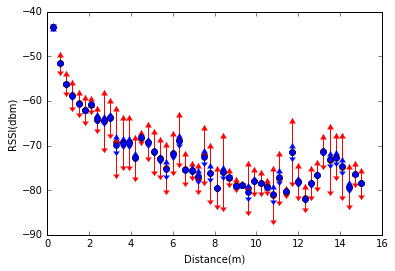

In [17]:
fig = plt.figure()
plt.errorbar(x, y, yerr=yerr, fmt='o',ecolor='r',color='r', uplims=True, lolims=True)
plt.errorbar(x, y_kf, yerr=yerr_kf, fmt='o',ecolor='b',color='b', uplims=True, lolims=True)
plt.xlabel("Distance(m)")
plt.ylabel("RSSI(dbm)")

### 测距模型介绍

测距模型论文推荐了第三种。
针对本次比赛的情况，分析最适合的模型。

可以舍弃一部分远距离的

拟合的技术流程
http://phy224.ca/19-curvefit/index.html

rssi 平滑
https://www.wouterbulten.nl/blog/tech/kalman-filters-explained-removing-noise-from-rssi-signals/

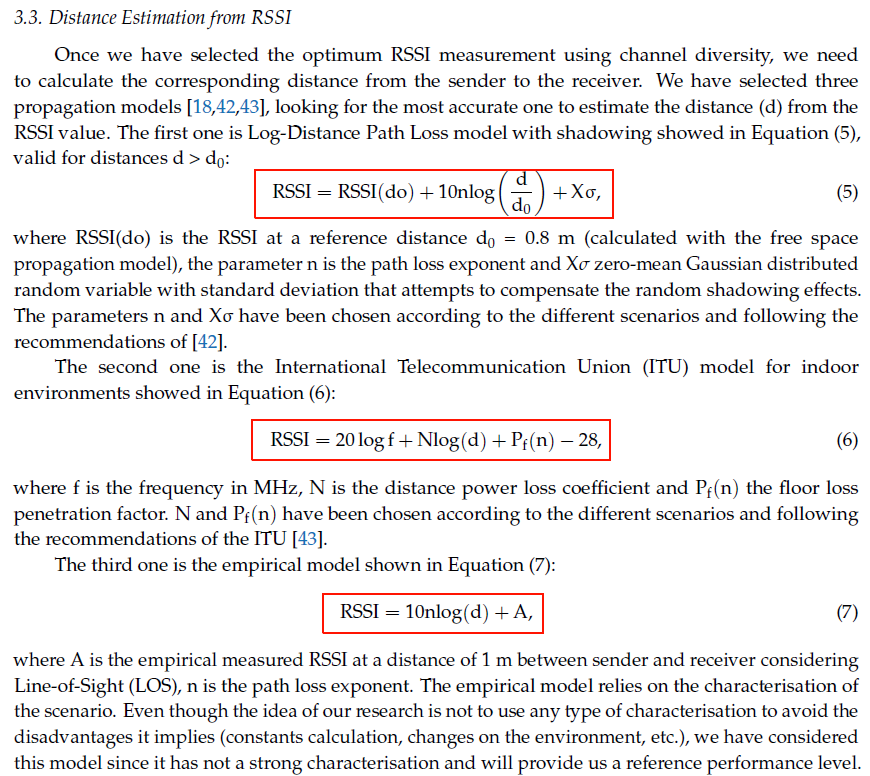

(0, 'a=', 1.0, 'b=', 1.0, 'c=', 1.0)
(1, 'a=', 1.0, 'b=', 1.0, 'c=', 1.0)
(2, 'a=', 1.0, 'b=', 1.0, 'c=', 1.0)
(3, 'a=', 1.0000000149011612, 'b=', 1.0, 'c=', 1.0)
(4, 'a=', 1.0, 'b=', 1.0000000149011612, 'c=', 1.0)
(5, 'a=', 1.0, 'b=', 1.0, 'c=', 1.0000000149011612)
(6, 'a=', 77.19199892187382, 'b=', 1.000001167729559, 'c=', 1.0)
(7, 'a=', 77.19200007212423, 'b=', 1.000001167729559, 'c=', 1.0)
(8, 'a=', 77.19199892187382, 'b=', 1.0000011826307376, 'c=', 1.0)
(9, 'a=', 77.19199892187382, 'b=', 1.000001167729559, 'c=', 1.0000000149011612)
(10, 'a=', 78.36447902457489, 'b=', 1.0000087185633595, 'c=', -0.17339350031973977)
(11, 'a=', 78.36448019229663, 'b=', 1.0000087185633595, 'c=', -0.17339350031973977)
(12, 'a=', 78.36447902457489, 'b=', 1.0000087334646506, 'c=', -0.17339350031973977)
(13, 'a=', 78.36447902457489, 'b=', 1.0000087185633595, 'c=', -0.17339349773597526)
(14, 'a=', 78.36575304520085, 'b=', 1.000023821040081, 'c=', -0.1760675336783647)
(15, 'a=', 78.36575421294157, 'b=', 1.0

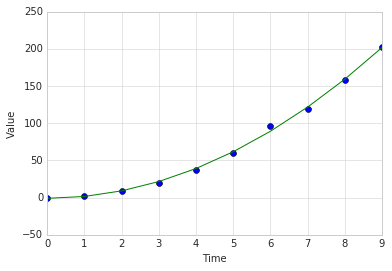

In [18]:
from scipy.optimize import curve_fit

iteration=0

def nonlinear_function(t, a, b, c):
    global iteration
    print (iteration, "a=",a, "b=",b, "c=",c)
    iteration = iteration+1
    return a*t**(b-1) + c

#generated "good" data
t = np.arange(10)
y1 = np.array([-0.173, 2.12, 9.42, 19.69, 37.16, 59.40, 96.59, 119.448, 158.0,201.9])
sigmaNL = np.ones(10)*0.5

iteration=0
poptNL1, pcovNL1 = curve_fit(nonlinear_function, t, y1,
                       absolute_sigma=True, sigma = sigmaNL)

plt.style.use("seaborn-whitegrid")
plt.errorbar(t, y1, yerr=sigmaNL, marker='o', linestyle='none')
plt.plot(t, nonlinear_function(t, poptNL1[0], poptNL1[1], poptNL1[2]))
plt.xlabel("Time")
plt.ylabel("Value")

(0, 'n=', 1.0, 'A=', 1.0)
(1, 'n=', 1.0, 'A=', 1.0)
(2, 'n=', 1.0, 'A=', 1.0)
(3, 'n=', 1.0000000149011612, 'A=', 1.0)
(4, 'n=', 1.0, 'A=', 1.0000000149011612)
(5, 'n=', -0.954072826391873, 'A=', -55.52091466689067)
(6, 'n=', -0.95407281217508, 'A=', -55.52091466689067)
(7, 'n=', -0.954072826391873, 'A=', -55.52091383956457)
(8, 'n=', -0.9540729721341702, 'A=', -55.52091068908248)
(9, 'n=', -0.9540729721341702, 'A=', -55.52091068908248)


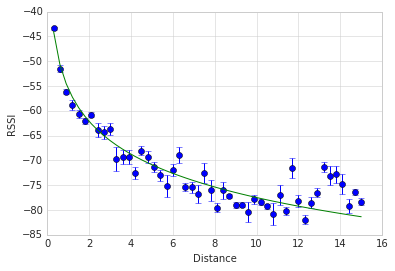

In [19]:
iteration=0
# RSSI = 10nlog(d)+A
def rssi(distance, n, A):
    global iteration
    print (iteration, "n=", n, "A=", A)
    iteration = iteration+1
    return 10*n*np.log(distance)+A

poptNL1, pcovNL1 = curve_fit(rssi, x, y_kf, absolute_sigma=False, sigma = yerr_kf)

plt.style.use("seaborn-whitegrid")
plt.errorbar(x, y_kf, yerr=yerr_kf, marker='o', linestyle='none')
x1 = x[:]
x1.sort()
plt.plot(x1, rssi(x1, poptNL1[0], poptNL1[1]))
plt.xlabel("Distance")
plt.ylabel("RSSI")

#### 使用Reduced chi squared衡量模型拟合结果

In [20]:
def chi2(y_measure,y_predict,errors):
    """Calculate the chi squared value given a measurement with errors and prediction"""
    return np.sum( (y_measure - y_predict)**2 / errors**2 )

def chi2reduced(y_measure, y_predict, errors, number_of_parameters):
    """Calculate the reduced chi squared value given a measurement with errors and prediction,
    and knowing the number of parameters in the model."""
    return chi2(y_measure, y_predict, errors)/(y_measure.size - number_of_parameters)

print(u"拟合模型 chi2r= {0}".format(chi2reduced(np.array(y), 
                                     rssi(np.array(x1), poptNL1[0], poptNL1[1]),
                                     np.array(yerr),
                                     2)))

(10, 'n=', -0.9540729721341702, 'A=', -55.52091068908248)
拟合模型 chi2r= 7.8627821637


#### 测距模型拟合结果

In [21]:
print(u'测距模型：RSSI = 10*%0.5f*log(d) + %0.5f'%(poptNL1[0], poptNL1[1]))

测距模型：RSSI = 10*-0.95407*log(d) + -55.52091


### 基于测距模型的定位方法

#### 测距模型的逆函数

In [22]:
from pynverse import inversefunc

RSSI101 = (lambda x: 10*poptNL1[0]*np.log(x)+poptNL1[1])
x_value = inversefunc(RSSI101, y_values=-55)
print("RSSI -55 -> Disatance: ", x_value)

# 由rssi计算distance
def rssi2distance(rssi, model=RSSI101):
    x_value = inversefunc(RSSI101, y_values=rssi)
    return x_value

print("RSSI -55 -> Disatance: ", rssi2distance(-55))

('RSSI -55 -> Disatance: ', array(0.94686512))
('RSSI -55 -> Disatance: ', array(0.94686512))


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


#### 通过MAC地址查找序号

In [23]:
# 通过MAC地址查找序号
def find_by_mac(mac, mac_db=base):
    idx = mac_db.index[mac_db[u'MAC地址'] == mac].tolist()
    record = mac_db.iloc[idx]
    name = str(record[u'序号'].values[0])
    x = float(record[u'X坐标'].values[0])
    y = float(record[u'Y坐标'].values[0])
    z = float(record[u'Z坐标'].values[0])
    return name, x, y, z

In [24]:
mac = 'A0:E6:F8:2D:1F:E8'
idx = base.index[base[u'MAC地址'] == mac].tolist()
record = base.iloc[idx]
name = str(record[u'序号'].values[0])
x = float(record[u'X坐标'].values[0])
y = float(record[u'Y坐标'].values[0])
z = float(record[u'Z坐标'].values[0])
print name, x, y, z

name, x, y, z = find_by_mac(mac, base)
print name, x, y, z

B14 1.8085 31.3284 2.0
B14 1.8085 31.3284 2.0


### 单一点的位置解算

In [25]:
f = open(u'静态定位点/1号点.txt', 'r')
src = {}
address = {}
mac_db = str(base[u'MAC地址'])
for line in f.readlines():
    t, _, mac, rssi = line.split()
    t = datetime.datetime.fromtimestamp(long(t)/1000.0)
    mac = mac.strip()
    if mac in mac_db:    
        name, x, y, z = find_by_mac(mac, base)
        if not src.has_key(name):
            src[name] = []
            address[name] = [mac, (x, y, z)]
        else:
            src[name].append(int(rssi))
    else:
        pass
        # print"Bad MAC:"+mac
    
f.close()

In [26]:
for k, v in src.items():
    # print k,v
    print(k, len(v), np.mean(v), np.std(v))

('B16', 65, -87.44615384615385, 1.8813315189045412)
('B10', 287, -85.53658536585365, 5.301819375337649)
('B17', 22, -93.54545454545455, 0.7820295697311479)
('B3', 395, -65.65316455696203, 1.6924879030690088)
('B14', 153, -88.640522875817, 2.1193610428307994)
('B4', 467, -60.359743040685224, 3.2058442247047116)
('B5', 225, -80.51555555555555, 2.9741071904433625)
('B6', 300, -79.06, 3.6999639637884765)
('B7', 261, -82.59386973180077, 0.999904577000638)
('B12', 218, -83.78899082568807, 1.5567161066209472)
('B1', 434, -54.6889400921659, 0.6458069514420445)
('B2', 412, -62.30339805825243, 2.129927321517729)
('B11', 240, -87.89583333333333, 1.877937513751604)
('B15', 27, -92.51851851851852, 1.9695904889345677)
('B19', 72, -90.09722222222223, 1.1803921455533117)
('B8', 323, -77.04643962848297, 1.6934616621447447)
('B9', 167, -88.25748502994011, 1.5043413099167373)
('B18', 83, -88.65060240963855, 1.0914093347126035)
('B13', 166, -88.27710843373494, 2.76079809053032)


### 观测值的卡尔曼滤波

-77.04643962848297 1.6934616621447447
-77.06542297688753 0.46905568050513846


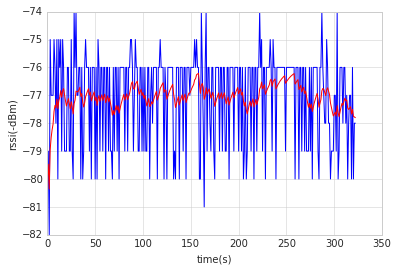

In [27]:
inputs = src['B8']
outputs = kf(inputs)
    
plt.plot(range(len(inputs)), inputs)
plt.plot(range(len(outputs)), outputs, color='r')
plt.xlabel('time(s)')
plt.ylabel('rssi(-dBm)')

print np.mean(inputs), np.std(inputs)
print np.mean(outputs), np.std(outputs)

#### 将原始观测数据进行滤波

In [28]:
src_out = {}
for k, v in src.items():
    src_out[k] = kf(v)

#### 可以采用最小二乘法，解算待定位点位坐标

mlat技术
https://en.wikipedia.org/wiki/Multilateration

python mlat库
https://github.com/gsongsong/mlat/tree/master/python

In [29]:
from mlat import MLAT

In [30]:
for k, v in address.items():
    src_ranges = [rssi2distance(r) for r in src_out[k]]
    rng = np.mean(src_ranges)
    err = np.std(src_ranges)
    if len(v)<5:
        v.append(rng)
        v.append(err)
        v.append(len(src_ranges))
    else:
        v[2] = rng
        v[3] = err
        v[4] = len(src_ranges)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
# 按照std进行过滤，把观测误差较大的基站移除
# 使用std以及距离，进行双重过滤
alpha = 1
beta = 15
num = 100
address_used = []
for k, v in address.items():
    if v[3]<=alpha and v[2]<= beta and v[4]>=num:
        address_used.append(list(v[1])+[v[2]]+[v[3]])
address_used = np.array(address_used)

In [50]:
address_used

array([[-1.1358    ,  9.6442    ,  2.        ,  2.89818829,  0.1382821 ],
       [ 1.7896    ,  7.2496    ,  2.        ,  1.66720966,  0.09840811],
       [-1.1397    ,  4.7248    ,  2.        ,  0.91522102,  0.02225951],
       [ 1.7725    ,  4.2468    ,  2.        ,  2.0390221 ,  0.09976294],
       [ 1.7796    , 16.8425    ,  2.        ,  9.57754997,  0.50316034]])

In [51]:
anchors = address_used[:,0:3]
print anchors
ranges = address_used[:, 3]
print ranges
errors = address_used[:, 4]
print errors # 如何将观测值的误差纳入模型之中

[[-1.1358  9.6442  2.    ]
 [ 1.7896  7.2496  2.    ]
 [-1.1397  4.7248  2.    ]
 [ 1.7725  4.2468  2.    ]
 [ 1.7796 16.8425  2.    ]]
[2.89818829 1.66720966 0.91522102 2.0390221  9.57754997]
[0.1382821  0.09840811 0.02225951 0.09976294 0.50316034]


In [52]:
bounds = np.zeros((2, anchors.shape[1]))
for i in range(anchors.shape[1]):
    bounds[0, i] = min(anchors[:, i]) # minimum boundary of ith axis
    bounds[1, i] = max(anchors[:, i]) # maximum boundary of ith axis

# 高程不需要定位，全等于2
bounds[0, -1] = 2
bounds[1, -1] = 2

estimator, result = MLAT.mlat(anchors, ranges, bounds_in=bounds, n_trial=500, alpha=0.001)

print('Anchors', anchors)
print('Ranges with error:', ranges)
print('Estimator', estimator)
#print('Full result')
#print(result)

('Anchors', array([[-1.1358,  9.6442,  2.    ],
       [ 1.7896,  7.2496,  2.    ],
       [-1.1397,  4.7248,  2.    ],
       [ 1.7725,  4.2468,  2.    ],
       [ 1.7796, 16.8425,  2.    ]]))
('Ranges with error:', array([2.89818829, 1.66720966, 0.91522102, 2.0390221 , 9.57754997]))
('Estimator', array([0.07270047, 6.43864939, 2.        ]))


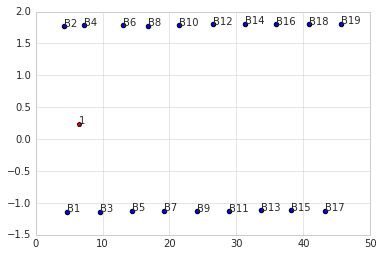

In [35]:
x = base[u'X坐标'].tolist()
y = base[u'Y坐标'].tolist()
labels = base[u'序号'].tolist()
macs = base[u'MAC地址'].tolist()

fig, ax = plt.subplots()
ax.scatter(y, x)

for i, txt in enumerate(labels):
    ax.annotate(txt, (y[i], x[i]))

ax.scatter(estimator[1], estimator[0], c = 'r',marker = 'p')
ax.annotate('1', (estimator[1], estimator[0]))

In [36]:
estimator

array([0.23993472, 6.50991522, 2.        ])

### 全部点位定位结果

In [37]:
flist = glob.glob(u'静态定位点/*.txt')

In [38]:
def locate_by_ble(fname, base=base):
    f = open(fname, 'r')
    src = {}
    address = {}
    mac_db = str(base[u'MAC地址'])
    
    for line in f.readlines():
        t, _, mac, rssi = line.split()
        mac = mac.strip()
        
        if mac in mac_db:    
            name, x, y, z = find_by_mac(mac, base)
            if not src.has_key(name):
                src[name] = []
                address[name] = [mac, (x, y, z)]
            else:
                src[name].append(int(rssi))

    f.close()
    
    # 增加卡尔曼滤波
    src_out = {}
    for k, v in src.items():
        if len(v)>0:
            src_out[k] = kf(v)
        else:
            src_out[k] = v
        
    for k, v in address.items():
        src_ranges = [rssi2distance(r) for r in src_out[k]]
        rng = np.mean(src_ranges)
        err = np.std(src_ranges)
        if len(v)<4:
            v.append(rng)
            v.append(err)
        else:
            v[2] = rng
            v[3] = err

    # 按照std进行过滤，把观测误差较大的基站移除
    alpha = 3
    beta = 10
    address_used = []
    
    for k, v in address.items():
        if v[2] <=beta and v[3]<=alpha and len(src_out[k])>= 100: #距离要近，方差要小，观测数据要多
            address_used.append(list(v[1])+[v[2]]+[v[3]])
    
    address_used = np.array(address_used)
    
    anchors = address_used[:, 0:3]
    ranges = address_used[:, 3]
    errors = address_used[:, 4]

    bounds = np.zeros((2, anchors.shape[1]))
    for i in range(anchors.shape[1]):
        bounds[0, i] = min(anchors[:, i]) # minimum boundary of ith axis
        bounds[1, i] = max(anchors[:, i]) # maximum boundary of ith axis

    # 高程不需要定位，全等于2
    bounds[0, -1] = 2
    bounds[1, -1] = 2

    estimator, result = MLAT.mlat(anchors, ranges, bounds_in=bounds, n_trial=500, alpha=0.001)
    return estimator, anchors, ranges, errors

In [39]:
xyz,_,_,_ = locate_by_ble(u'静态定位点/1号点.txt', base)
xyz

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


array([0.26111539, 6.39758975, 2.        ])

In [40]:
result = []
for f in flist:
    txt = os.path.basename(f)[0:-4]
    print txt
    xyz,_,_,_ = locate_by_ble(f, base)
    x, y, z = xyz
    result.append([txt, y, x])

10号点


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


11号点


E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
E:\Anaconda\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


12号点
13号点
14号点
15号点
1号点
2号点
3号点
4号点
5号点
6号点
7号点
8号点
9号点


B1,4.7248,-1.1397
B2,4.2468,1.7725
B3,9.6442,-1.1358
B4,7.2496,1.7896
B5,14.4456,-1.1225
B6,13.0025,1.786
B7,19.1635,-1.1236
B8,16.8425,1.7796
B9,24.0482,-1.1266
B10,21.3653,1.7885
B11,28.8415,-1.1319
B12,26.4415,1.8059
B13,33.6452,-1.1119
B14,31.3284,1.8085
B15,38.1864,-1.1123
B16,35.9027,1.7995
B17,43.2589,-1.1234
B18,40.8239,1.8032
B19,45.6426,1.8072
10,28.900113617500033,-1.1179232094018636
11,31.732102500896204,-0.7140342710986682
12,35.37012374777378,-0.10738029154431517
13,40.03745206602708,1.751721856563304
14,42.70707036213363,1.7570950147550068
15,38.26043181517324,0.9120801985452676
1,6.5131686659059795,-0.13373336060784502
2,8.260767930451902,1.7627528522766038
3,6.867745889061554,-1.0127890188275743
4,8.639704764246389,-0.6728697773382903
5,15.116728784436004,0.513860216160545
6,17.084910523074832,0.5069073710221819
7,15.493348834485325,-1.022115761437088
8,18.88944012954467,1.6434979999428332
9,26.38505127537752,0.4367800870601002


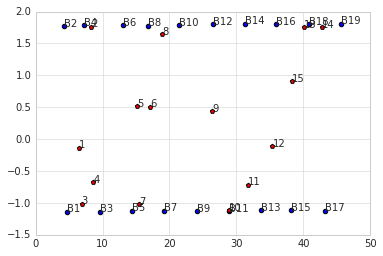

In [41]:
x = base[u'X坐标'].tolist()
y = base[u'Y坐标'].tolist()
labels = base[u'序号'].tolist()
macs = base[u'MAC地址'].tolist()

fig, ax = plt.subplots()
#ax.axis('equal')
ax.scatter(y, x)

for i, txt in enumerate(labels):
    ax.annotate(txt, (y[i], x[i]))
    print ','.join([txt, str(y[i]), str(x[i])])

for i in result:
    ax.scatter(i[1], i[2], c = 'r',marker = 'p')
    ax.annotate(i[0][0:-2], (i[1], i[2]))
    print ','.join([i[0][0:-2], str(i[1]), str(i[2])])
    